# Мэтчинг товаров

### Описание проекта

#### Задача
Разработка алгоритма, который для всех товаров из `validation.csv` найдет 5 похожих из `base.csv`
#### Метрика
Необходимо максимилизировать метрику `accuracy@5`, которая для каждого объекта вычисляется по формуле:
\begin{equation}
\text{accuracy\@5} = 100 \cdot \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}}{5}
\end{equation}
#### Данные
Исходные: https://disk.yandex.ru/d/YQElc_cNQQLSOw
- `base.csv`:
- `train.csv`:
- `validation.csv`:
- `validation_answer.csv`:

#### План работы
- Загрузка необходимых библиотек
- Ознакомление с данными
- Предобработка данных
- Поиск оптимальных параметров Fiass

## Загрузка необходимых библиотек



Установим необходимые библиотеки:

In [21]:
!pip -q install faiss-gpu
!pip install scikit-learn tqdm pandas matplotlib seaborn catboost


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Импортируем библиотеки:

In [56]:
import zipfile
from urllib.parse import urlencode

import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Ознакомление с данными

Код для загрузки исходных данных:

In [57]:
def downloader(size: str = 'small'):
    if size not in ['small', 'large']:
        raise Exception('Unknown Argument')
    elif size == 'small':
        public_key = 'https://disk.yandex.ru/d/YQElc_cNQQLSOw'
    else:
        public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)
    with open('./content/data.zip', 'wb') as f:
        f.write(download_response.content)

    zip_path = './content/data.zip'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('./dataset')

In [58]:
%%time
download_files = False
download_size = 'small'

if download_files:
    downloader(download_size)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


Загрузим данные `base.csv`:

In [59]:
%%time
df_base = pd.read_csv("./dataset/base.csv", index_col=0)
df_base.head()

CPU times: user 2.45 s, sys: 134 ms, total: 2.58 s
Wall time: 2.58 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,45.090958,-126.84374,4.494522,-99.842310,44.926903,177.52173,-12.291790,38.470360,105.357650,-142.46024,-80.163260,-110.368935,1047.517357,-69.594620,66.313540,84.873870,813.770071,-81.038780,16.162964,-98.244880,159.53406,27.554913,-209.184280,62.05977,-529.295053,114.598330,90.469894,-20.256914,-164.76800,-133.31387,-41.252960,-10.251193,8.289038,-131.312710,75.704500,-16.483078,40.771038,-146.096740,-143.407680,49.807987,63.434480,-30.250080,20.470263,78.079910,-128.915310,92.327680,63.885570,-141.17464,142.902590,-93.068596,-568.421584,-90.018690,-129.015670,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,201.472200,-186.22650,29.896042,-99.770996,0.126302,136.19049,-35.224740,-30.321323,-43.148834,-162.85175,-79.714510,-75.784870,1507.231274,-69.654564,43.640663,-4.779669,813.770071,43.976913,11.924875,-50.228523,166.00820,-59.505333,-115.332520,72.18324,-735.671365,96.322300,85.796360,-22.030330,-147.54501,-108.38295,-45.084892,-15.004004,-1.532826,-46.456585,197.578950,-56.199876,60.298710,-102.653340,-108.967964,58.512012,-9.678028,-85.448300,-68.686080,71.590200,-232.425690,91.706856,63.290657,-137.33595,-47.124687,-148.057400,-543.787056,-160.651600,-133.462220,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,105.715180,-149.80756,-54.501680,-21.037973,-24.887660,128.38864,-58.558483,34.862656,19.784412,-130.91820,-79.032230,-166.635250,1507.231274,-8.495993,61.205086,25.895348,813.770071,-140.768860,20.872790,-123.957570,126.34781,11.713674,-125.025154,152.68590,-1018.469545,-22.444600,73.897640,9.190645,-156.51881,-92.18573,-34.926760,-13.277475,16.026424,-33.853546,119.604520,-52.525341,71.204750,-178.702940,-88.278500,30.501453,16.651737,-88.377014,-55.883583,70.182980,-89.233925,92.005780,76.458725,-131.14087,40.914352,-157.900540,-394.319235,-87.107025,-120.772545,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,110.324326,-161.18800,-68.519790,-0.607330,38.733696,120.74344,-14.109269,28.868027,-29.858810,-94.30395,-79.339810,-138.984270,1507.231274,-131.885380,70.031360,32.736595,813.770071,-62.370860,13.763219,-31.872276,139.55270,9.836465,-150.221130,80.14020,-537.183707,3.091667,129.699330,-63.429424,-169.02724,-119.77007,-28.637785,-8.315162,2.752385,-160.293820,85.086890,-18.251750,90.374054,1.479935,-121.983050,65.852660,8.355225,34.118896,-57.069756,70.461800,-127.905410,94.314280,71.259940,-135.57787,-39.982346,-159.751560,-230.147648,-95.221160,-148.814090,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,191.465850,-156.98384,-76.650210,-75.674970,12.624029,145.33752,-35.774258,11.598761,-11.460761,-201.35443,-77.779366,-120.968400,548.736883,19.851685,17.943344,27.063320,813.770071,-85.483780,21.236433,-95.071020,132.61092,13.526038,-160.476840,104.71937,-304.174382,-15.385452,91.418655,-36.474556,-157.43959,-102.83162,-56.782710,-19.969252,-0.598189,-222.228790,33.441666,-56.092110,71.276030,-8.713509,-86.099380,8.488903,-14.959278,86.812996,-29.6

Посмотрим на размерность:

In [60]:
df_base.shape

(291813, 72)

Загрузим данные `train.csv`:

In [61]:
%%time
df_train = pd.read_csv("./dataset/train.csv", index_col=0)
df_train.head()

CPU times: user 106 ms, sys: 81 µs, total: 106 ms
Wall time: 105 ms


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,-149.211060,-102.31221,21.387623,11.277594,143.22140,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,407.773575,-11.660624,67.008150,24.975033,813.770071,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.095570,133.786470,-906.571061,113.355560,83.942260,-16.592659,-146.52074,-120.237860,-27.341612,-8.845615,1.027612,-175.647720,167.735820,-32.931559,47.860960,-196.247500,-118.81005,-4.762772,-114.877680,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.513430,-136.27057,3.652915,-164.574510,-635.284275,-75.647255,-116.679340,-41.234684,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,76.202880,-137.799420,33.30165,-2.868191,-34.318770,189.06479,-19.337550,-14.208210,-71.110245,-157.74814,-78.70069,-91.741875,1054.205600,-41.845630,102.128620,72.559050,813.770071,-37.957787,17.598982,-159.975400,140.02528,-8.819328,-147.055180,113.819870,-529.295053,70.674940,55.976795,8.817799,-134.14812,-73.679794,-57.566544,-4.338496,-3.270682,-144.499200,144.650200,-37.903276,58.913525,-105.362840,-125.66783,19.367283,-29.087658,-35.021350,26.627962,55.718437,-110.52611,83.513374,75.926130,-135.68242,-7.429803,-180.645020,11.470171,16.464691,-121.807236,-90.814450,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,112.190155,-200.925960,-38.86518,-80.611270,14.343805,156.62129,-22.498169,-26.359468,-109.034870,-106.92659,-79.74731,-69.876830,1507.231274,-20.058287,34.334927,23.592144,813.770071,-49.503860,22.166200,-85.740160,134.83647,-69.569850,-139.887240,67.377045,-341.781842,54.161224,81.891660,36.421352,-159.99583,-131.916080,-20.495195,-13.976569,-2.355247,-216.228650,238.836490,-56.611536,43.366640,7.191841,-159.48369,-19.338009,-51.409897,36.819540,32.536880,80.681020,-232.40741,84.053690,59.086180,-139.85950,78.409440,-115.940575,2.426572,7.594826,-126.520134,-73.148960,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,120.074790,-61.347084,-28.67060,-102.790180,-36.194320,157.18976,-33.318240,7.448413,-47.230713,-178.04608,-78.78652,-106.235440,1507.231274,-63.414307,38.099255,-89.795350,813.770071,-107.432390,10.052701,-71.917380,147.74005,-18.750763,-143.795620,67.207310,-366.139446,112.187700,78.144810,-41.085410,-132.75719,-89.445030,-19.267069,-14.866466,7.775788,-104.302110,74.622894,-59.875136,76.406470,-77.797020,-92.01658,19.337300,-37.922787,37.271270,111.639570,94.912950,-179.72540,86.601480,62.698364,-122.16293,29.873940,-53.508120,-0.938894,-36.919907,-144.555000,-96.798590,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,172.365360,-186.641390,-84.94380,-92.339966,-30.229528,167.86163,-22.635653,0.014536,-9.796367,-213.10180,-78.59006,-98.728300,1250.423749,-43.892487,86.288450,-1.549826,813.770071,-110.356980,24.055641,-96.578270,156.58230,45.124240,-123.888504,118.035110,-607.946912,52.311410,76.747800,-14.161914,-143.53851,-124.886215,-64.783330,-17.706848,15.446568,-53.554455,174.381620,-23.140892,76.419330,-73.

Посмотрим на размерность:

In [62]:
df_train.shape

(9999, 73)

Загрузим данные `validation.csv` и `validation_answer.csv`:

In [63]:
df_valid = pd.read_csv("./dataset/validation.csv", index_col=0)
answers = pd.read_csv("./dataset/validation_answer.csv", index_col=0)

Посмотрим на размерность:

In [64]:
answers.shape

(10000, 1)

Посмотрим на размерность:

In [65]:
df_valid.shape

(10000, 72)

## Предобработка данных

Создадим дополнительные функции для предобработки:

In [77]:
def isna_rate(df):
    isna_df = (pd.DataFrame(round(df.isna().mean()*100,2)).sort_values(by=0, ascending=False))
    isna_df.columns = ['Процент пропусков']
    na_df = isna_df.query('`Процент пропусков` > 0')
    if len(na_df) == 0:
        print("Пропуски отсутствуют")
    else:
        display(na_df.style.background_gradient('coolwarm'))

def check_duplicated(df):
    # проверка на дубликаты
    dupl = df.duplicated().sum()
    print("Количество дубликатов:", dupl)
    if dupl == 0:
        print("Дубликаты отсутсвуют.")

Проверим на пропуски `df_base`:

In [67]:
isna_rate(df_base)

Пропуски отсутствуют


Проверим на дубликаты `df_base`:

In [68]:
check_duplicated(df_base)

Количество дубликатов: 11278


Удалим дубликаты:

In [69]:
df_base.drop_duplicates(inplace=True)

Проверим на пропуски `df_train`:

In [81]:
isna_rate(df_train)

Пропуски отсутствуют


Проверим на дубликаты `df_train`:

In [82]:
check_duplicated(df_train)

Количество дубликатов: 243


Удалим дубликаты:

In [83]:
df_train.drop_duplicates(inplace=True)

## Иследовательский анализ данных

Создадим дополнительные функции для анализа:

In [101]:
def check_unique_rate(df):
    display(df.apply(lambda col: col.nunique() / len(col) * 100).sort_values())
    
#Анализ распределения данных в каждом столбце (гистограммы)
def plot_histograms(df, columns, n_rows, n_cols):
    fig = plt.figure(figsize=(16, 16))
    for i, col in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[col].hist(ax=ax)
        ax.set_title(col)
    plt.tight_layout()
    plt.show()
    
#Анализ выбросов
def plot_boxplots(df, columns, n_rows, n_cols):
    fig = plt.figure(figsize=(16, 16))
    for i, col in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        sns.boxplot(data=df[col], ax=ax)
        ax.set_title(col)
    plt.tight_layout()
    plt.show()
    
def get_min_iqr(describe):
    # получаем минимальное значение уса как было описано в уроке Диаграмма размаха
    min_value = describe['min']
    q1 = describe['25%']
    q3 = describe['75%']
    iqr = q3 - q1 
    return max(q1 - 1.5 * iqr, min_value)

def get_max_iqr(describe):
    # получаем максимальное значение уса как было описано в уроке Диаграмма размаха
    max_value = describe['max']
    q1 = describe['25%']
    q3 = describe['75%']
    iqr = q3 - q1 
    return min(q3 + 1.5 * iqr, max_value)

def iqr_1_5(df, column):
    # вычисление iqr
    describe = df[column].describe()
    min_iqr = get_min_iqr(describe)
    max_iqr = get_max_iqr(describe)
    ratio = ((df[df[column] < min_iqr][column].count() + df[df[column] > max_iqr][column].count())/len(df)) * 100
    return {"Колонка": column, "min iqr": min_iqr, "max iqr": max_iqr, "Процент выбросов": round(ratio, 2)}
    
def quantitative_info(df):
    data = []
    # для количественного признака
    for column in df.loc[:, df.columns !='id'].select_dtypes(include='number').columns.tolist():
        data.append(iqr_1_5(df, column))
    return pd.DataFrame(data)

Посмотрим на процент уникальных значений:

In [102]:
check_unique_rate(df_base)

33     0.977062
44     7.450051
25    14.173633
21    27.537740
70    57.495500
19    66.460869
6     78.086513
66    79.876308
56    86.549272
54    87.120324
37    87.382680
29    87.469300
8     87.773718
61    88.012547
3     89.848326
38    90.049726
55    90.418664
52    90.551981
69    90.851052
14    90.920919
31    90.937316
64    91.072059
35    91.228189
27    91.228545
10    91.237813
0     91.296273
20    91.314809
18    91.318374
32    91.336197
43    91.444205
47    91.469514
62    91.472009
5     91.486624
4     91.526547
53    91.589641
58    91.593919
39    91.601404
9     91.638120
42    91.643823
23    91.659508
15    91.671984
45    91.705135
28    91.707987
1     91.716185
11    91.755752
65    91.761456
71    91.779635
68    91.786052
63    91.811004
46    91.812073
40    91.830253
12    91.853066
2     91.863404
26    91.863404
48    91.864830
60    91.866256
34    91.874454
17    91.891564
24    91.904040
41    91.904753
67    91.929349
49    91.937191
22    91

Построим гистрограммы:

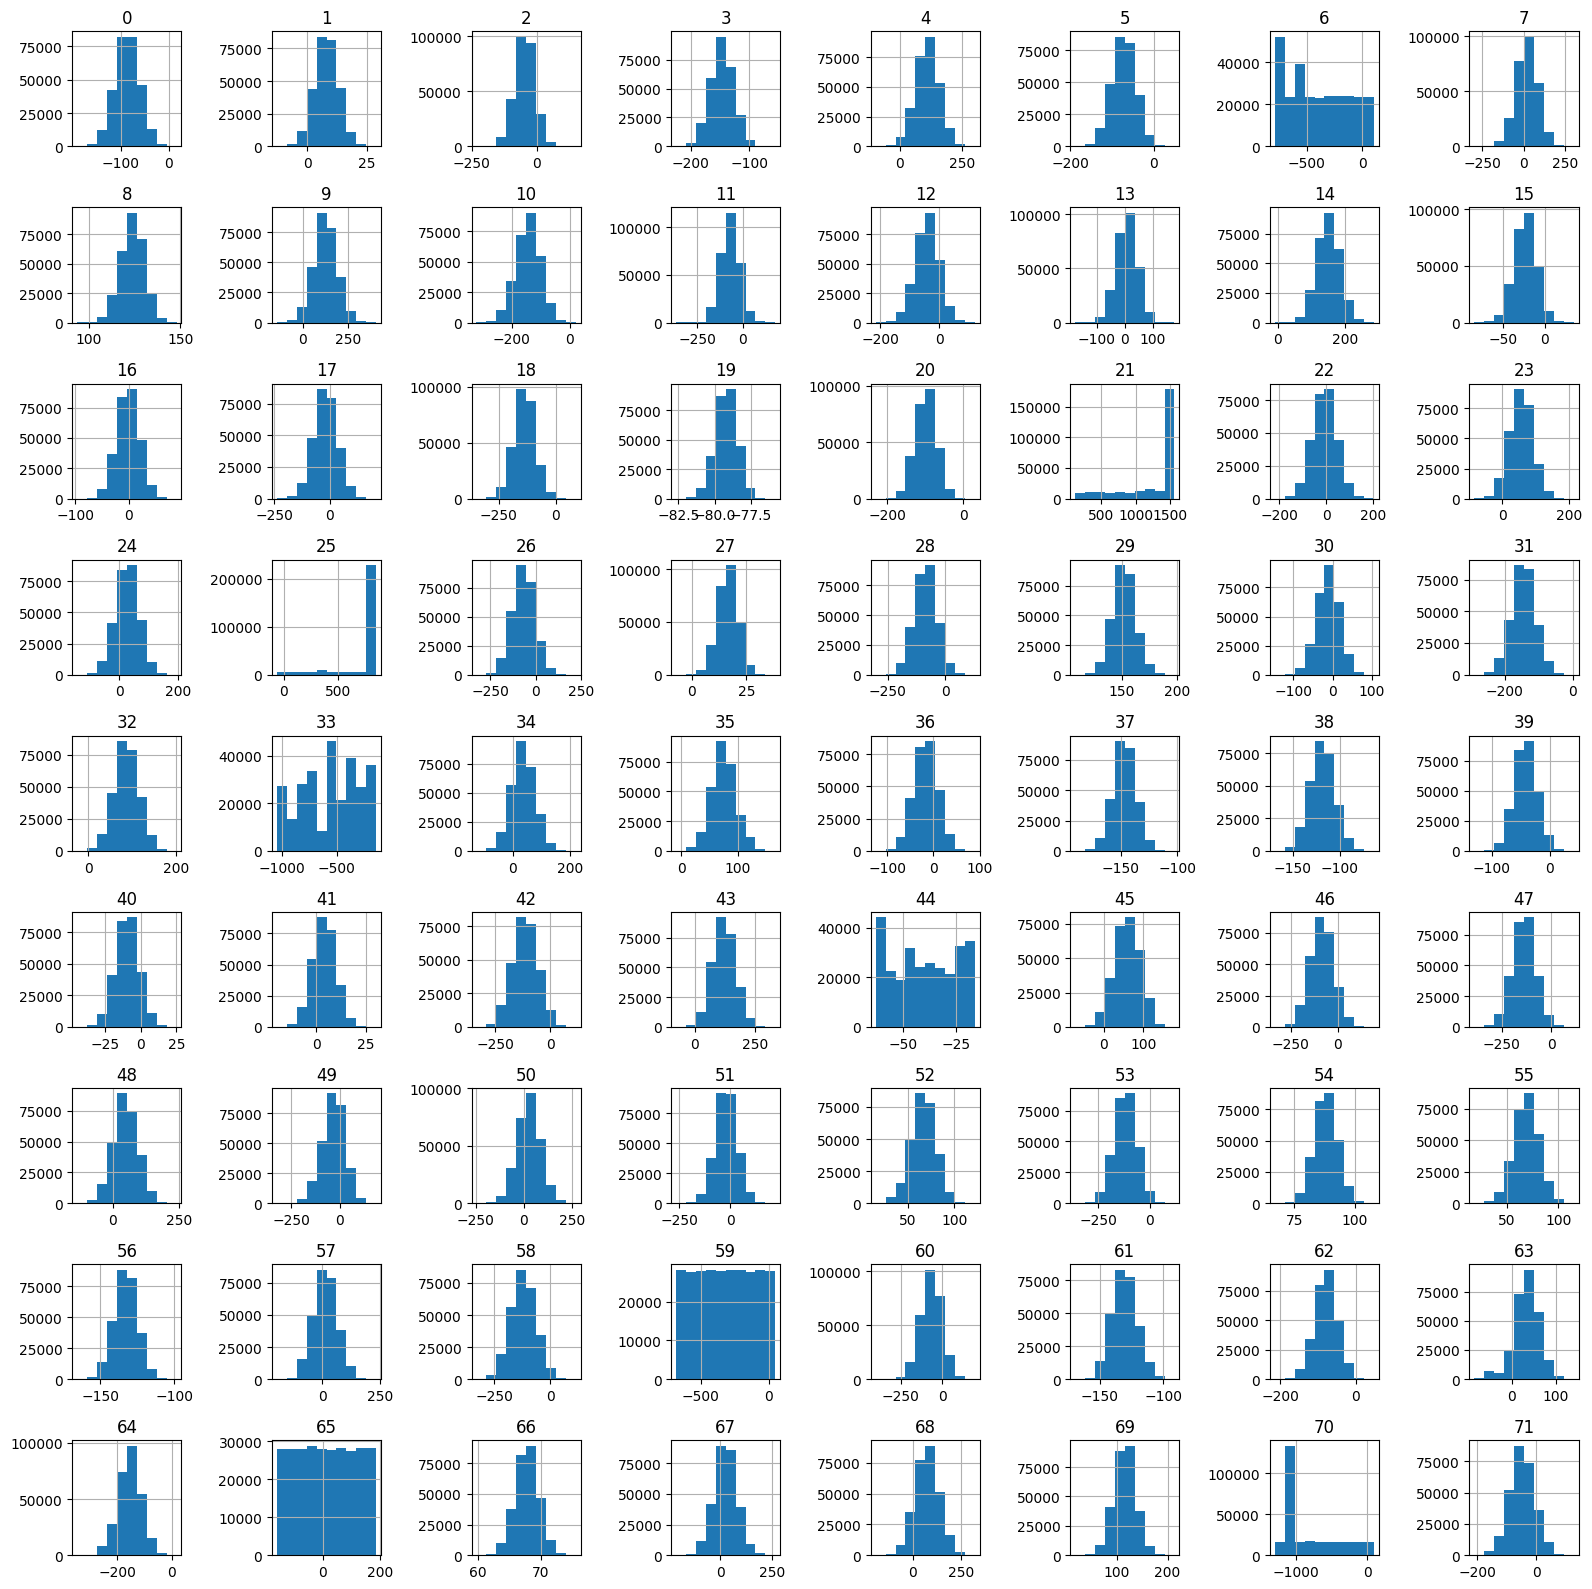

In [103]:
plot_histograms(df_base, df_base.columns, 9, 8) 

Построим boxplot:

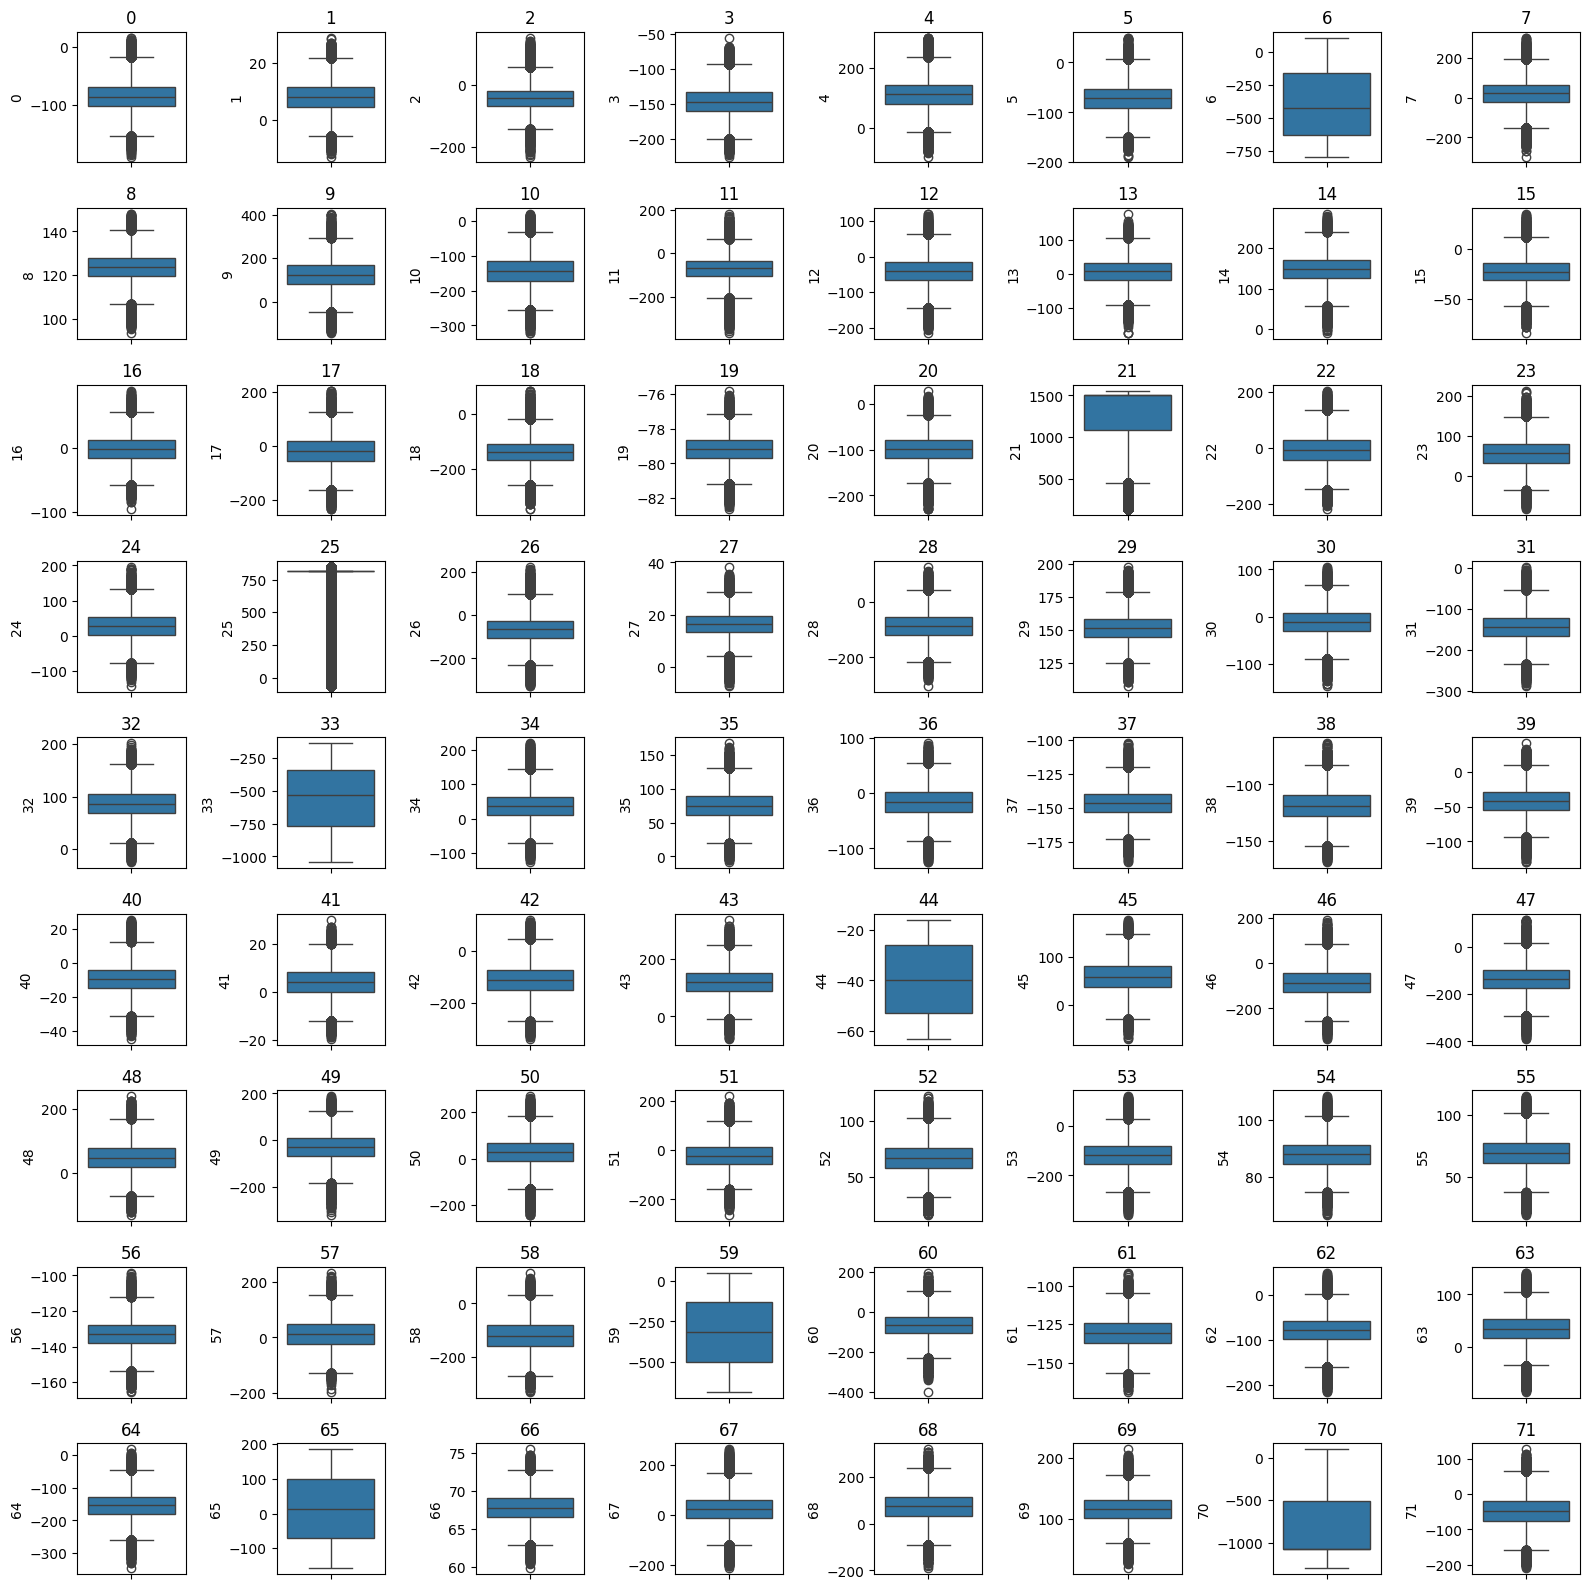

In [104]:
plot_boxplots(df_base, df_base.columns, 9, 8)

Найдем выбросы и их процент:

In [105]:
quantitative_info(df_base).sort_values(by="Процент выбросов", ascending=False)

,Колонка,min iqr,max iqr,Процент выбросов
25,25,813.770071,813.770071,20.42
21,21,455.683967,1557.418340,8.16
63,63,-35.775574,104.814956,3.45
18,18,-257.861665,-17.447985,1.42
2,2,-144.308638,55.115463,1.27
67,67,-120.830108,168.022182,1.15
19,19,-81.181261,-77.178031,1.06
69,69,59.733980,171.569500,1.04
15,15,-57.946777,11.783913,0.98
29,29,124.843928,178.323388,0.97


## Отбор признаков

In [163]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [164]:
def train(k):
    X = df_train.drop('Target', axis=1)  # Ваши признаки
    y = df_train['Target']  # Ваши метки

    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit_transform(X, y)

    features_names = selector.get_feature_names_out()
    print(features_names)

    n_cells = 100
    n_probe = 10
    m = 32

    scaler = StandardScaler()
    df_base_scaled = scaler.fit_transform(df_base[features_names])

    dims = df_base_scaled.shape[1]
    hnsw_index = faiss.IndexHNSWFlat(dims, m)
    ivf_index = faiss.IndexIVFFlat(hnsw_index, dims, n_cells, faiss.METRIC_L2)

    ivf_index.train(np.ascontiguousarray(df_base_scaled).astype('float32'))
    ivf_index.add(np.ascontiguousarray(df_base_scaled).astype('float32'))

    targets = df_train["Target"]
    df_train_scaled = scaler.transform(df_train[features_names])

    candidate_number = 5
    ivf_index.nprobe = n_probe
    r, idx = ivf_index.search(np.ascontiguousarray(df_train_scaled).astype('float32'), candidate_number)

    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    print(f'Accuracy k={k} @ {candidate_number} = {acc / len(idx):.1%}')
    return r, idx, df_train_scaled, df_base_scaled, features_names, ivf_index, scaler

In [165]:
distances, indices, df_train_scaled, df_base_scaled, features_names, ivf_index, scaler = train(67)

['0' '1' '2' '3' '4' '5' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '22' '23' '24' '26' '27' '28' '29' '30' '31' '32'
 '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44' '45' '46' '47'
 '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58' '60' '61' '62'
 '63' '64' '65' '66' '67' '68' '69' '70' '71']
Accuracy k=67 @ 5 = 77.6%


In [166]:
results = []

reverse_base_index = {v: k for k, v in enumerate(df_base.index.to_list())}
train_targets = df_train['Target'].values

for i, (neighbors, true_target) in enumerate(zip(indices, train_targets)):
    real_row = {
        "index_in_train": i,
        "index_in_base": reverse_base_index[true_target],
        "match": 1
    }
    results.append(real_row)

    for neighbor_idx in neighbors:
        base_target = base_index[neighbor_idx]
        match = int(base_target == true_target)
        result_row = {
            "index_in_train": i,
            "index_in_base": neighbor_idx,
            "match": match
        }
        if match == 0:
            results.append(result_row)

result_df = pd.DataFrame(results)
result_df

,index_in_train,index_in_base,match
0,0,173444,1
1,0,228939,0
2,0,207200,0
3,0,34565,0
4,0,143627,0
...,...,...,...
50956,9755,225793,0
50957,9755,90570,0
50958,9755,86712,0
50959,9755,179586,0


In [167]:
# Вытаскиваем строки из df_train по индексам, которые в result_df
joined_rows1 = df_train.iloc[result_df['index_in_train']][features_names]
joined_rows2 = df_base.iloc[result_df['index_in_base']][features_names]

In [168]:
result_merged = result_df.join(joined_rows1.reset_index(drop=True), rsuffix="train")
result_merged = result_merged.join(joined_rows2.reset_index(drop=True), rsuffix="base")
result_merged = result_merged.drop(['index_in_train', 'index_in_base'], axis=1)
result_merged

,match,0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,65,66,67,68,69,70,71,0base,1base,2base,3base,4base,5base,7base,8base,9base,10base,11base,12base,13base,14base,15base,16base,17base,18base,19base,20base,22base,23base,24base,26base,27base,28base,29base,30base,31base,32base,34base,35base,36base,37base,38base,39base,40base,41base,42base,43base,44base,45base,46base,47base,48base,49base,50base,51base,52base,53base,54base,55base,56base,57base,58base,60base,61base,62base,63base,64base,65base,66base,67base,68base,69base,70base,71base
0,1,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.90313,-75.284454,120.55149,131.13170,-149.211060,-102.312210,21.387623,11.277594,143.2214,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,-11.660624,67.008150,24.975033,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.09557,133.78647,113.355560,83.94226,-16.592659,-146.52074,-120.23786,-27.341612,-8.845615,1.027612,-175.64772,167.73582,-32.931559,47.860960,-196.247500,-118.81005,-4.762772,-114.87768,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.51343,-136.27057,3.652915,-164.57451,-75.647255,-116.67934,-41.234684,-24.601670,-167.76077,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-75.284454,120.55149,131.131700,-149.211060,-102.312210,21.387623,11.277594,143.22140,-22.011570,-3.618249,-16.005480,-133.38228,-78.893560,-65.690530,-11.660624,67.008150,24.975033,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.09557,133.786470,113.355560,83.942260,-16.592659,-146.52074,-120.237860,-27.341612,-8.845615,1.027612,-175.64772,167.73582,-32.931559,47.860960,-196.247500,-118.81005,-4.762772,-114.877680,37.397278,-55.616966,56.627056,-108.433170,87.372560,76.513430,-136.27057,3.652915,-164.574510,-75.647255,-116.67934,-41.234684,-24.601670,-167.76077,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750
1,0,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.90313,-75.284454,120.55149,131.13170,-149.211060,-102.312210,21.387623,11.277594,143.2214,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,-11.660624,67.008150,24.975033,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.09557,133.78647,113.355560,83.94226,-16.592659,-146.52074,-120.23786,-27.341612,-8.845615,1.027612,-175.64772,167.73582,-32.931559,47.860960,-196.247500,-118.81005,-4.762772,-114.87768,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.51343,-136.27057,3.652915,-164.57451,-75.647255,-116.67934,-41.234684,-24.601670,-167.76077,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,-48.846200,5.992617,-55.368250,-116.868350,187.253170,-81.231606,27.263393,119.81758,135.253980,-165.725780,-71.870186,-40.234580,-45.569122,155.20792,-17.406261,-6.893937,22.609634,-164.59500,-77.799100,-62.588604,-18.239431,62.300415,55.793983,41.994660,22.362585,-61.236412,160.83138,-59.260864,-185.19191,120.071290,78.862310,79.717140,-28.130680,-140.65718,-120.417410,-41.385930,-10.002274,-2.940303,-176.52094,153.43988,-42.856559,27.216520,-157.841000,-158.95898,11.816677,-179.665130,31.418596,-102.152430,48.348965,-131.756150,87.522060,80.760086,-134.45348,9.508688,-148.452220,-104.005770,-132.62540,-51.514830,-15.232170,-179.77888,138.817506,70.132540,21.591990,61.820120,108.707490,-974.831307,-39.296950
2,0,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.90313,-75.284454,120.55149,131.13170,-149.211060,-102.312210,21.387623,11.277594,143.2214,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,-11.660624,67.008150,24.975033,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.09557,133.78647,113.355560,83.94226,-16.592659,-146.52074,-120.23786,-27.341612,-8.845615,1.027612,-175.64772,167.73582,-32.931559,47.860960,-196.247500,-118.81005,-4.762772,-11

In [169]:
X = result_merged.drop('match', axis=1)  # Ваши признаки
y = result_merged['match']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_catboost = StandardScaler()
X_train_scaled = scaler_catboost.fit_transform(X_train)
X_val_scaled = scaler_catboost.transform(X_val)

model = CatBoostClassifier(iterations=1000,
                           depth=6,
                           learning_rate=0.01,
                           loss_function='Logloss',
                           verbose=10)

model.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val))

0:	learn: 0.6886661	test: 0.6887609	best: 0.6887609 (0)	total: 58ms	remaining: 58s
10:	learn: 0.6487267	test: 0.6497259	best: 0.6497259 (10)	total: 202ms	remaining: 18.1s
20:	learn: 0.6153215	test: 0.6170928	best: 0.6170928 (20)	total: 341ms	remaining: 15.9s
30:	learn: 0.5887243	test: 0.5911841	best: 0.5911841 (30)	total: 494ms	remaining: 15.4s
40:	learn: 0.5668545	test: 0.5699795	best: 0.5699795 (40)	total: 644ms	remaining: 15.1s
50:	learn: 0.5493727	test: 0.5531159	best: 0.5531159 (50)	total: 784ms	remaining: 14.6s
60:	learn: 0.5350294	test: 0.5392894	best: 0.5392894 (60)	total: 925ms	remaining: 14.2s
70:	learn: 0.5229913	test: 0.5276903	best: 0.5276903 (70)	total: 1.07s	remaining: 14s
80:	learn: 0.5099565	test: 0.5150912	best: 0.5150912 (80)	total: 1.21s	remaining: 13.7s
90:	learn: 0.5009377	test: 0.5064735	best: 0.5064735 (90)	total: 1.35s	remaining: 13.5s
100:	learn: 0.4920471	test: 0.4978787	best: 0.4978787 (100)	total: 1.5s	remaining: 13.3s
110:	learn: 0.4854356	test: 0.4916060	

In [170]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val_scaled)
# Calculating accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.87


In [171]:
df_valid_scaled_search = scaler.transform(df_valid[features_names])
r, neighbors = ivf_index.search(np.ascontiguousarray(df_valid_scaled_search).astype('float32'), 50)

In [177]:
i = 0
count = 0
for neighbor in neighbors:
    results = []
    for nei in neighbor:
        check_row = {
            "index_in_valid": i,
            "index_in_base": nei
        }
        results.append(check_row)

    df_valid_check = pd.DataFrame(results)
    joined_rows1 = df_train.iloc[df_valid_check['index_in_valid']][features_names]
    joined_rows2 = df_base.iloc[df_valid_check['index_in_base']][features_names]

    result_merged = df_valid_check.join(joined_rows1.reset_index(drop=True), rsuffix="train")
    result_merged = result_merged.join(joined_rows2.reset_index(drop=True), rsuffix="base")
    result_merged = result_merged.drop(['index_in_valid', 'index_in_base'], axis=1)
    result_merged_scaled = scaler_catboost.transform(result_merged)
    y_pred = model.predict(result_merged_scaled)
    if (y_pred != 0).any():
        count += 1
        print(i, y_pred)
    i += 1
print(count / len(neighbors))


1480 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
2285 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
2935 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
3002 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
4769 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
5429 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
8882 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


IndexError: positional indexers are out-of-bounds